# Summary and Explanations. #

Title: Improving Music Genre Classification using Song Lyrics. 

Hypothesis: Lyrics does contain important information not shown in the audio features itself that can improve audio classifiers.

Dataset: Contains Audio Features and Song Lyrics with Music genre as label and artist_and_song as unique identifyer.

Preparation: see the two notebooks below containing filtering, analysis and workflow for this project.
- data_analysis_for_prototype.ipynb
- song_text_data.ipynb

Resources: Custom built data set combining datapoints from
- Audio Features data: https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db
- Text Lyrics data: https://www.kaggle.com/datasets/edenbd/150k-lyrics-labeled-with-spotify-valence

# Imports and load custom data-set. #

In [1]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

data = pd.read_csv('/kaggle/input/text-mining-project-dataset/Project_dataset.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data preparation #

In [2]:
print("Amount of datapoints with unique song+artist: ", len(data))

Amount of datapoints with unique song+artist:  12440


In [3]:
data.genre.value_counts()

Country             1738
Ska                 1687
Blues               1469
Folk                1144
Dance                995
Rock                 917
Electronic           911
Reggae               864
Soul                 804
R&B                  469
Jazz                 431
Pop                  387
Hip-Hop              234
Indie                152
Children’s Music     122
Rap                  116
Name: genre, dtype: int64

After careful consideration the whole point is to answer the question of this project and therefore I will remove genres below 500 datapoints. I do this because of two reasons:
- Analysis and plots will be less congested with overflowing amounts of classes.
- Removing classes with too few datapoints will balance out the dataset and make the classification easier for the models.

The downside is that the model becomes less general, and not adapted to the real world (where there are many music genres.)

In [4]:
# Create a filter for genres with value counts >= 500
valid_genres = data.genre.value_counts()
genres_to_keep = valid_genres[valid_genres >= 500].index

# Subset the DataFrame based on the filter
data = data[data.genre.isin(genres_to_keep)]

data.genre.value_counts()

Country       1738
Ska           1687
Blues         1469
Folk          1144
Dance          995
Rock           917
Electronic     911
Reggae         864
Soul           804
Name: genre, dtype: int64

In [5]:
print('Dummy accuracy:', round(100 * 1738 / len(data) ), '%')

Dummy accuracy: 17 %


In [6]:
# Encode the categorical data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in data.columns:
    if col in ['key', 'mode', 'time_signature', 'genre']:

        data[col] = le.fit_transform(data[col])
        data[col] = data[col].astype("category")

data.head()

,genre,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_and_song,Lyrics
0,1,0.0293,0.387,234307,0.874,0.000017,3,0.1710,-4.528,0,0.0530,168.105,2,0.674,gary allan /// get off on the pain,I don't know why I love women\r\nThat love to ...
1,1,0.1730,0.633,183600,0.444,0.000003,5,0.0821,-14.090,0,0.0264,106.111,1,0.450,"hank williams, jr. /// old habits","I kicked the habit, of smoking back some time ..."
2,1,0.0600,0.493,262720,0.780,0.000248,3,0.1920,-4.127,0,0.0485,119.996,2,0.190,carrie underwood /// chaser,I need something strong tonight\nI'm needing m...
3,1,0.7730,0.687,320040,0.543,0.000002,10,0.7050,-10.151,0,0.0521,129.296,3,0.807,bobby bare /// the winner,The hulk of a man with a beer in his hand he l...
4,1,0.0655,0.618,226187,0.790,0.006410,9,0.1100,-4.973,0,0.0445,119.987,2,0.545,brooks & dunn /// proud of the house we built,I dropped to my knees in that field on your da...


In [7]:
data.genre.value_counts()

1    1738
7    1687
0    1469
4    1144
2     995
6     917
3     911
5     864
8     804
Name: genre, dtype: int64

In [8]:
data.genre

0        1
1        1
2        1
3        1
4        1
        ..
12435    8
12436    8
12437    8
12438    8
12439    8
Name: genre, Length: 10529, dtype: category
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]

### Prepare the datasets for audio feature and text classification

In [9]:
labels = data.genre
audio_data = data.drop(columns=['genre', 'artist_and_song','Lyrics'])

# Audio classification train test data.
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(audio_data, labels, test_size=0.2,random_state=42)

# print(X_test_audio)
# Create train test data for text classification.
idx_train = X_train_audio.index
idx_test = X_test_audio.index

X_train_text = data.loc[idx_train].Lyrics.tolist()
X_test_text = data.loc[idx_test].Lyrics.tolist()
y_train_text = y_train_audio.tolist()
y_test_text = y_test_audio.tolist()



In [10]:
# Scale the data for Audio classification.
scaler = StandardScaler()
X_train_audio = scaler.fit_transform(X_train_audio)
X_test_audio = scaler.transform(X_test_audio)

# Audio Feature Classifications (MLP, Naive Bayes, XGBoost, TabNet)

In [11]:
# Initialize the model
MLP_clf = MLPClassifier()#hidden_layer_sizes=(256,128,64), max_iter=200)

# Train the model
MLP_clf.fit(X_train_audio, y_train_audio)
MLP_y_pred = MLP_clf.predict(X_test_audio)
MLP_y_proba_pred = MLP_clf.predict_proba(X_test_audio)

# Calculate the classification report for this fold
MLP_report = classification_report(y_test_audio, MLP_y_pred)
print(MLP_report)


              precision    recall  f1-score   support

           0       0.41      0.36      0.38       332
           1       0.47      0.69      0.56       366
           2       0.42      0.33      0.37       195
           3       0.49      0.59      0.53       163
           4       0.40      0.36      0.38       225
           5       0.49      0.50      0.50       162
           6       0.29      0.15      0.20       175
           7       0.72      0.76      0.74       333
           8       0.31      0.25      0.27       155

    accuracy                           0.48      2106
   macro avg       0.44      0.44      0.44      2106
weighted avg       0.46      0.48      0.47      2106



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
naive_clf = GaussianNB()
naive_clf.fit(X_train_audio, y_train_audio)

naive_y_pred = naive_clf.predict(X_test_audio)

# Calculate the classification report for this fold
naive_report = classification_report(y_test_audio, naive_y_pred)
print(naive_report)

              precision    recall  f1-score   support

           0       0.48      0.07      0.13       332
           1       0.37      0.73      0.50       366
           2       0.32      0.34      0.33       195
           3       0.48      0.40      0.43       163
           4       0.37      0.39      0.38       225
           5       0.38      0.49      0.43       162
           6       0.30      0.15      0.20       175
           7       0.59      0.69      0.64       333
           8       0.24      0.12      0.16       155

    accuracy                           0.41      2106
   macro avg       0.39      0.38      0.35      2106
weighted avg       0.41      0.41      0.37      2106



In [13]:
# !pip install pytorch-tabnet

In [14]:
# from pytorch_tabnet.tab_model import TabNetClassifier

# tabnet_clf = TabNetClassifier()
# tabnet_clf.fit(X_train_audio, y_train_audio)

In [15]:
# tabnet_y_pred = tabnet_clf.predict(X_test_audio)
# tabnet_report = classification_report(y_test_audio, tabnet_y_pred)
# print(tabnet_report)

In [16]:
# !pip install xgboost

In [17]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_audio, y_train_audio)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [18]:
xgb_y_pred = xgb_clf.predict(X_test_audio)
xgb_report = classification_report(y_test_audio, xgb_y_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       332
           1       0.51      0.63      0.56       366
           2       0.43      0.39      0.41       195
           3       0.53      0.55      0.54       163
           4       0.37      0.41      0.39       225
           5       0.48      0.50      0.49       162
           6       0.28      0.20      0.23       175
           7       0.73      0.76      0.75       333
           8       0.30      0.23      0.26       155

    accuracy                           0.49      2106
   macro avg       0.45      0.45      0.45      2106
weighted avg       0.48      0.49      0.48      2106



In [19]:
best_XGB_params = {
                'max_depth': 4,
                'learning_rate': 0.03711299495104505,
                'n_estimators': 447,
                'min_child_weight': 10,
                'gamma': 0.002238238469617126,
                'subsample': 0.849826493051354,
                'colsample_bytree': 0.9977007889943236,
                'reg_alpha': 0.15538382519234734,
                'reg_lambda': 7.07955517130104e-07,
                'enable_categorical' : True,
                'tree_method' : "hist"
               }

xgb2_clf = xgb.XGBClassifier(**best_XGB_params)

xgb2_clf.fit(X_train_audio, y_train_audio)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9977007889943236, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.002238238469617126, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03711299495104505, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=447, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [20]:
xgb2_y_pred = xgb2_clf.predict(X_test_audio)
xgb2_report = classification_report(y_test_audio, xgb2_y_pred)
print(xgb2_report)

              precision    recall  f1-score   support

           0       0.44      0.42      0.43       332
           1       0.50      0.66      0.57       366
           2       0.44      0.40      0.42       195
           3       0.57      0.61      0.59       163
           4       0.38      0.39      0.39       225
           5       0.50      0.54      0.52       162
           6       0.30      0.15      0.20       175
           7       0.76      0.79      0.77       333
           8       0.34      0.25      0.29       155

    accuracy                           0.50      2106
   macro avg       0.47      0.47      0.46      2106
weighted avg       0.49      0.50      0.49      2106



In [21]:
#!pip install imbalanced-learn==0.7.0

In [22]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=42)

# X_res, y_res = sm.fit_resample(X_train_audio, y_train_audio)

# print("Inspect oversampling: \n",y_res.value_counts())

# xgb3_clf = xgb.XGBClassifier()#**best_XGB_params)

# xgb3_clf.fit(X_res, y_res)

In [23]:
# xgb3_y_pred = xgb3_clf.predict(X_test_audio)
# xgb3_report = classification_report(y_test_audio, xgb3_y_pred)
# print(xgb3_report)

In [24]:
# tabnet2_clf = TabNetClassifier()
# tabnet2_clf.fit(X_res, y_res)

In [25]:
# tabnet2_y_pred = tabnet2_clf.predict(X_test_audio)
# tabnet2_report = classification_report(y_test_audio, tabnet2_y_pred)
# print(tabnet2_report)


# Text Classification (Finetuning BERT)

In [26]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [27]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [28]:
# #Some testing 
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# text = X_train_text[120]
# print(text)
# test = tokenizer(text)
# test

In [29]:
def processing_for_bert(batch, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
    
    N = len(batch)
    texts, final_labels = [0]*N, [0]*N
    
    for i in range(N):
        
        texts[i] = batch[i][0]
        final_labels[i] = batch[i][1] 

    #pad to longest length of longest sentence in batch!
    tokenized = tokenizer(texts, padding=True, max_length=512, truncation=True)
    #print(tokenized)
    token_id = torch.tensor(tokenized['input_ids'])
    attention_masks = torch.tensor(tokenized['attention_mask'])
    return token_id.to(device), attention_masks.to(device), torch.tensor(final_labels).to(device) 

# token_id, attention_masks, labels = processing_for_bert(X_train_text[:2], y_train_text[:2])  

In [30]:
# Function to calculate the accuracy of our predictions
def accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #print(pred_flat)
    #print(labels_flat)
    return np.sum(preds_flat == labels_flat)/len(preds_flat)

In [31]:
def create_label_map(num_categories):

    #mapping for labels
    zero_vec = [0] * num_categories 
    label_map = {}
    for i in range(num_categories-1):
        gold_vec = zero_vec.copy()
        gold_vec[i] = 1
        label_map[i] = gold_vec
    # print(label_map)
    return label_map

def create_text_data(X,Y):
    """Create data of shape [(x1,y1), (x2,y2),...,]"""
    data = []
    for i in range(len(X)):
        data.append((X[i],Y[i]))
    return data

In [32]:
def train_model(train_data, n_epochs=3, batch_size=16, lr=1e-5):
    # mapping for labels
    num_categories = 9  # Nine music genres
    # label_map = create_label_map(num_categories)

    # Prepare the data loaders
    train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=processing_for_bert)

    # Build the classifier
    classifier = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_categories).to(device)

    # Initialise the optimizer
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

    # Training loop
    try:
        for epoch in range(n_epochs):
            train_losses = 0
            classifier.train()
            for batch in tqdm(train_loader):
                train_token_id = batch[0]
                train_attention_masks = batch[1]
                train_labels = batch[2]

                # Reset the accumulated gradients
                optimizer.zero_grad()

                # Forward pass
                output = classifier(train_token_id,
                                    token_type_ids=None,
                                    attention_mask=train_attention_masks,
                                    labels=train_labels)

                # Save loss
                train_losses += output.loss.item()

                # Backward pass; propagates the loss and computes the gradients
                output.loss.backward()
                # Update the parameters of the model
                optimizer.step()

            print('epoch_avg_train_loss:', round(train_losses / len(train_loader), 3))

        # Save model parameters
        torch.save(classifier.state_dict(), 'trained_model.pth')

    except KeyboardInterrupt:
        pass

    return classifier


In [33]:
def test_model(classifier, test_data, batch_size=16):
    
    test_loader = DataLoader(test_data, batch_size, collate_fn=processing_for_bert)

    classifier.eval()

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            val_token_id = batch[0]
            val_attention_masks = batch[1]
            val_labels = batch[2]

            output = classifier(val_token_id,
                                token_type_ids=None,
                                attention_mask=val_attention_masks,
                                labels=val_labels)

            # Convert logits to probabilities using softmax
            probs = F.softmax(output.logits, dim=1)
            all_probs.append(probs)

            # Store predictions and true labels for computing the weighted F1 later
            preds_flat = np.argmax(output.logits.detach().cpu().numpy(), axis=1)
            all_preds.extend(preds_flat.tolist())
            all_labels.extend(val_labels.to('cpu').numpy().tolist())

    report = classification_report(all_labels, all_preds)
        
    all_probs_tensor = torch.cat(all_probs, dim=0)
    return report, all_probs_tensor, all_preds


In [34]:
text_train_data = create_text_data(X_train_text, y_train_text)
text_test_data = create_text_data(X_test_text, y_test_text)

In [35]:
model = train_model(text_train_data)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

epoch_avg_train_loss: 1.874


100%|██████████| 527/527 [07:59<00:00,  1.10it/s]


epoch_avg_train_loss: 1.438


100%|██████████| 527/527 [08:00<00:00,  1.10it/s]


epoch_avg_train_loss: 1.155


In [36]:
text_pred_report, text_pred_probs, text_preds = test_model(model, text_test_data)

100%|██████████| 132/132 [00:52<00:00,  2.50it/s]


In [37]:
print(text_pred_report)

              precision    recall  f1-score   support

           0       0.59      0.28      0.38       332
           1       0.54      0.86      0.67       366
           2       0.49      0.42      0.45       195
           3       0.50      0.54      0.52       163
           4       0.40      0.35      0.37       225
           5       0.75      0.52      0.61       162
           6       0.37      0.16      0.22       175
           7       0.54      0.78      0.64       333
           8       0.39      0.39      0.39       155

    accuracy                           0.52      2106
   macro avg       0.51      0.48      0.47      2106
weighted avg       0.52      0.52      0.49      2106



In [48]:
# print(text_preds)

In [39]:
# Save the array
if isinstance(text_pred_probs, torch.Tensor):
    text_pred_probs = text_pred_probs.cpu().numpy()
np.save('text_pred_probs.npy', text_pred_probs)

# Plotting and Analysis

In [40]:
import matplotlib.pyplot as plt
import re
import seaborn as sns

def plot_f1_scores(cr, class_names):
    # Split the report into lines
    lines = cr.split('\n')
    
    f1_scores = []

    # For each line, extract the F1-score
    for line in lines[2:-5]:  # Skipping initial and last few lines with average scores
        t = re.split(r'\s+', line.strip())
        f1_scores.append(float(t[3]))
    
    # Plotting
    plt.bar(class_names, f1_scores, color='g', edgecolor='grey')
    plt.xlabel('Classes', fontweight='bold', fontsize=15)
    plt.ylabel('F1-Score', fontweight='bold', fontsize=15)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    


def plot_correlation(v1, v2, class_names=None):
    """
    Plots the correlation between two vectors v1 and v2 using a confusion matrix.
    """
    if len(v1) != len(v2):
        raise ValueError("Both vectors should have the same length")

    # Determine the unique classes from the vectors
    if class_names:
        classes = np.arange(len(class_names))
    else:
        classes = np.unique(np.concatenate([v1, v2]))

    # Create a confusion matrix
    confusion_matrix = np.zeros((len(classes), len(classes)))

    for i, j in zip(v1, v2):
        confusion_matrix[i, j] += 1

    # Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names or classes, yticklabels=class_names or classes)
    plt.xlabel(f"Predictions from v2")
    plt.ylabel(f"Predictions from v1")
    plt.title("Correlation between Two Classification Predictions")
    plt.show()


### Text vs Audio Feature Predictions

In [41]:
# Music genres mapped with correct category num
class_names = ["Blues", "Country", "Dance", "Electronic", "Folk", "Reggae", "Rock", "Ska", "Soul"]

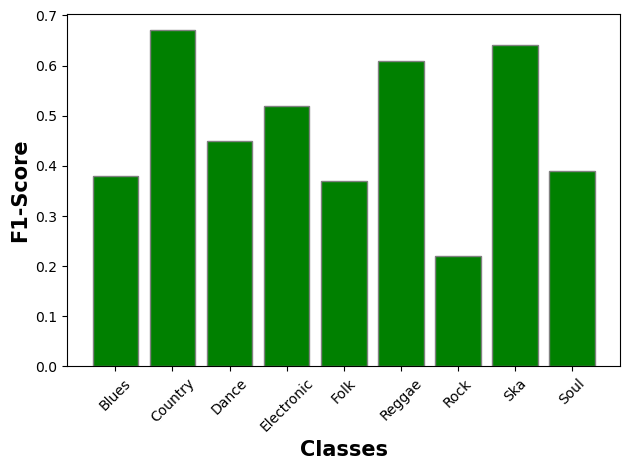

In [42]:
plot_f1_scores(text_pred_report, class_names)

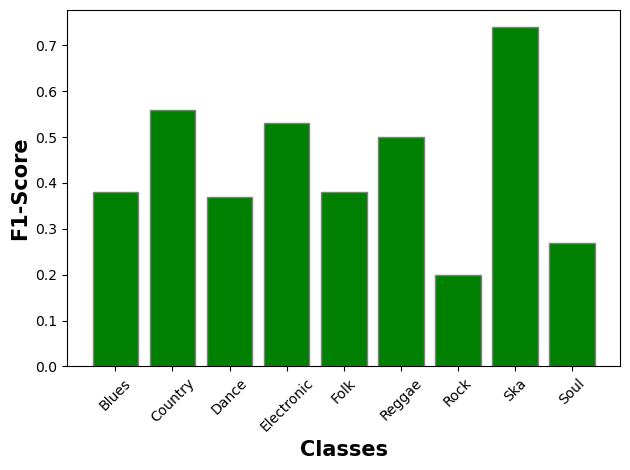

In [43]:
plot_f1_scores(MLP_report, class_names)

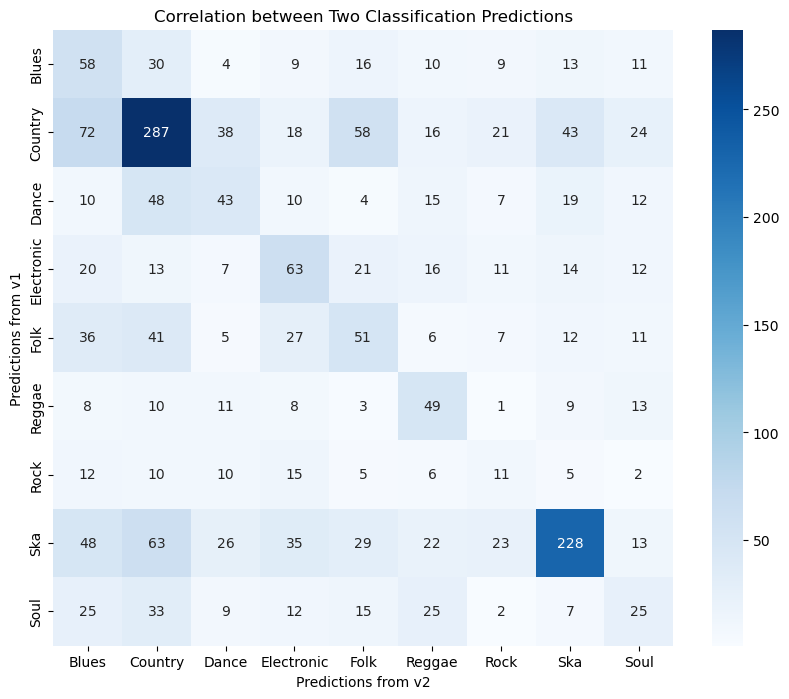

In [44]:
plot_correlation(text_preds, MLP_y_pred, class_names)

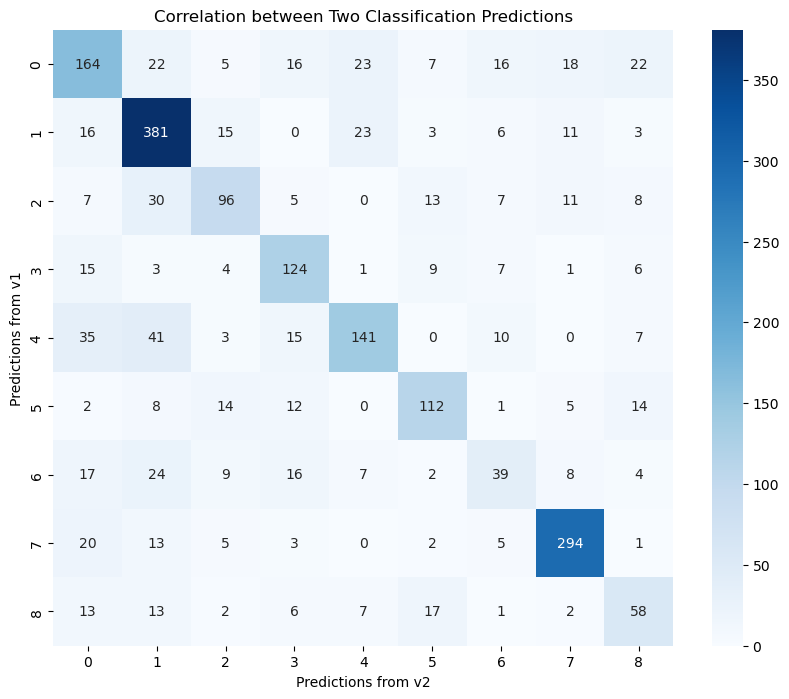

In [45]:
plot_correlation(xgb_y_pred, MLP_y_pred)

In [46]:
from sklearn.metrics import cohen_kappa_score
kappa1 = cohen_kappa_score(text_preds, MLP_y_pred)
kappa2 = cohen_kappa_score(xgb_y_pred, MLP_y_pred)
print(kappa1)
print(kappa2)

0.2779387023140999
0.6157432288278573


In [47]:
# Load the numpy array
loaded_probs_array = np.load('/kaggle/working/text_pred_probs.npy')
print(loaded_probs_array)
# Convert the numpy array back to a tensor if needed
loaded_probs_tensor = torch.tensor(loaded_probs_array)

[[0.24249326 0.01049087 0.02033425 ... 0.14256701 0.22871391 0.09179246]
 [0.01862535 0.00269601 0.02537053 ... 0.08913103 0.6648238  0.00772592]
 [0.00944026 0.00532344 0.67391276 ... 0.04375071 0.04041724 0.06939624]
 ...
 [0.02245918 0.00311237 0.00425375 ... 0.02937384 0.89137375 0.00729628]
 [0.16219768 0.01391178 0.02900094 ... 0.14484753 0.05315141 0.0255508 ]
 [0.16596098 0.20152025 0.01847036 ... 0.32106295 0.22398463 0.02625543]]


# Combining the models